In [1]:
!pip -q install spacy==2.0.18
!python -m spacy download en

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 46.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.7/612.7 kB 52.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.4/443.4 kB 47.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  error: subproce

In [2]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip

Archive:  imdb.zip
  inflating: test.tsv                
  inflating: train.tsv               


# Логистическая регрессия на PyTorch

Дедлайн: 9.03. Но готовьтесь, что будет наложение со следующими дз. Скопируйте ноутбук себе, решите задания. Откройте ноутбук для редактирования. Отправьте ссылку на ноутбук в форму.  https://forms.gle/MWNQqFbUaZvwB5j56

----

В этой домашней работы вам предстоит написать логистическую регрессию и решить задачу классификации текстов

Мы будем классифицировать отзывы с IMDB на положительные и отрицательные.

Данные взяты с  http://ai.stanford.edu/~amaas/data/sentiment/

In [3]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


In [4]:
train_df.head()

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...


### Предобработка данных [1 балл]

В рамках этой работы познакомимся с эмбеддингами - векторными представлениями слов.

Сначала, мы должны разбить сырой текст на слова. Этот процесс называется токенизацией. Воспользуемся уже готовым алгоритмом токенизации для английского языка с помощью библиотеки SpaCy.   

In [5]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

text = "This is a sentence"

tokens = tokenizer(text)
assert len(tokens) == 4

print("Original text : {}".format(text))
print("Tokenized text: {}".format(list(tokens)))

Original text : This is a sentence
Tokenized text: [This, is, a, sentence]


Чтобы не терять время на обработку токенизацию всех данных, давайте загрузим уже токенизированные тексты обучающей и тестовой выборок

In [6]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d1-5FwxK53ePwygNWeG7jhsOWZbi5HOv'})
downloaded.GetContentFile('train_docs.pkl')

downloaded = drive.CreateFile({'id': '1MMOY477t965G0C5DtXeREVp0X85UaNq5'})
downloaded.GetContentFile('test_docs.pkl')

In [7]:
import pickle

with open('train_docs.pkl', 'rb') as f:
    train_docs = pickle.load(f)

with open('test_docs.pkl', 'rb') as f:
    test_docs = pickle.load(f)

In [8]:
train_tokenized_texts = [[token for token, _ in doc[0]] for doc in train_docs]
test_tokenized_texts = [[token for token, _ in doc[0]] for doc in test_docs]

Посмотрим на исходный текст:

In [9]:
train_df.review.iloc[0]

'Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisingly thin and lacking

А теперь на токенезированный:

In [10]:
print(train_tokenized_texts[0])

['Dreamgirls', ',', 'despite', 'its', 'fistful', 'of', 'Tony', 'wins', 'in', 'an', 'incredibly', 'weak', 'year', 'on', 'Broadway', ',', 'has', 'never', 'been', 'what', 'one', 'would', 'call', 'a', 'jewel', 'in', 'the', 'crown', 'of', 'stage', 'musicals', '.', 'However', ',', 'that', 'is', 'not', 'to', 'say', 'that', 'in', 'the', 'right', 'cinematic', 'hands', 'it', 'could', 'not', 'be', 'fleshed', 'out', 'and', 'polished', 'into', 'something', 'worthwhile', 'on', '-', 'screen', '.', 'Unfortunately', ',', 'what', 'transfers', 'to', 'the', 'screen', 'is', 'basically', 'a', 'slavishly', 'faithful', 'version', 'of', 'the', 'stage', 'hit', 'with', 'all', 'of', 'its', 'inherent', 'weaknesses', 'intact', '.', 'First', ',', 'the', 'score', 'has', 'never', 'been', 'one', 'of', 'the', 'strong', 'points', 'of', 'this', 'production', 'and', 'the', 'film', 'does', 'not', 'change', 'that', 'factor', '.', 'There', 'are', 'lots', 'of', 'songs', '(', 'perhaps', 'too', 'many', '?', ')', ',', 'but', 'few

Что ж, нам все равно нужно заранее знать длину последовательности. Чтобы ускорить процесс, мы можем сократить слишком длинные обзоры. Давайте воспользуемся гистограммой, чтобы понять, где нужно обрезать:

<BarContainer object of 220 artists>

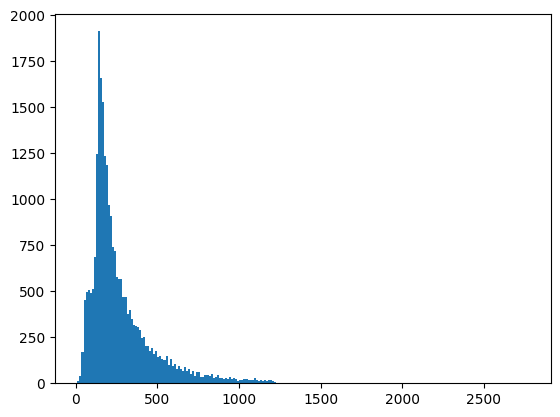

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist([len(text) for text in train_tokenized_texts], bins='auto')
hist

Другая проблема: слова должны быть пронумерованы. Нам нужно построить словарь,который будет каждому слову ставить в соответствие опредленное число (индекс в словаре).


In [12]:
from collections import Counter

def build_word2idx(tokenized_texts, min_df):
    # count each word (in lower case) occurence in the tokenized text ( apply str.lower() for each word )
    words_counter = Counter(map(str.lower , [x for xs in tokenized_texts for x in xs]))

    word2idx = {
        '<pad>': 0,
        '<unk>': 1
    }
    for word, count in words_counter.most_common():
        if count < min_df:
            break

        word2idx[word] = len(word2idx)

    return word2idx


word2idx = build_word2idx(train_tokenized_texts, 10)
print('Words count:', len(word2idx))

Words count: 20269


Посмотрим на то, что у нас получилось:

In [13]:
print(word2idx)

{'<pad>': 0, '<unk>': 1, 'the': 2, ',': 3, '.': 4, 'and': 5, 'a': 6, 'of': 7, 'to': 8, 'is': 9, 'it': 10, 'in': 11, 'i': 12, 'this': 13, 'that': 14, '"': 15, "'s": 16, '-': 17, 'was': 18, 'as': 19, ' ': 20, 'for': 21, 'with': 22, 'movie': 23, 'but': 24, 'film': 25, ')': 26, 'on': 27, 'you': 28, '(': 29, "n't": 30, 'not': 31, 'are': 32, 'he': 33, 'his': 34, 'have': 35, 'be': 36, 'one': 37, 'all': 38, '!': 39, 'at': 40, 'they': 41, 'by': 42, 'an': 43, 'who': 44, 'so': 45, 'from': 46, 'like': 47, 'there': 48, 'her': 49, 'or': 50, 'just': 51, 'do': 52, 'about': 53, "'": 54, 'has': 55, 'out': 56, 'if': 57, 'what': 58, '?': 59, 'some': 60, 'good': 61, 'more': 62, 'she': 63, 'when': 64, 'very': 65, 'would': 66, 'up': 67, 'time': 68, 'no': 69, 'even': 70, 'my': 71, 'can': 72, 'which': 73, 'story': 74, 'only': 75, 'really': 76, 'had': 77, 'see': 78, 'their': 79, 'were': 80, 'we': 81, 'me': 82, 'well': 83, 'did': 84, 'does': 85, 'than': 86, 'much': 87, '...': 88, ':': 89, 'could': 90, 'get': 91,

Используя `word2idx` и число `max_text_len`, которые мы можем определить по гистограмме позволит нам конвертировать наши тексты в матрицу.

А какую матрицу?

Те, кто работали с sklearn может быть помнят, что `CountVectorizer` конвертировал список текстов в матрицу следующим образом:

$$
\begin{align}
& \text{the movie was excellent} \\
& \text{the movie was extremely awful}
\end{align}
\to
 \begin{pmatrix}
  1 & 1 & 1 & 1 & 0 & 0 \\
  1 & 1 & 1 & 0 & 1 & 1
 \end{pmatrix}
$$

Первая строка матрицы соответствует первому предложению, вторая..., ну вы поняли.

Первый столбец говорит о том, сколько раз слово `the` встречается в конкретном предложении, последняя - сколько раз появляется слово `awful` и так далее.

Такое представление текста дает нам вектор фиксированной длины, но он не учитывает порядок слов.

И теперь мы будем строить вектор переменной (почти) длинны для каждого текста.
Его длина должна быть равна минимуму между длиной самого текста и параметром  `max_text_len`.

В каждую позицию такого вектора мы будем записывать для слова из текста соответствующий ему индекс в словаре с помощью  `word2idx`.

Для примера, получим вектора двух следующих ппредложений таким образом:

In [14]:
dummy_texts = ['the movie was excellent', 'the movie was extremely awful']
dummy_tokenized_texts = [text.split() for text in dummy_texts]

dummy_word2idx = build_word2idx(dummy_tokenized_texts, 0)

dummy_word2idx

{'<pad>': 0,
 '<unk>': 1,
 'the': 2,
 'movie': 3,
 'was': 4,
 'excellent': 5,
 'extremely': 6,
 'awful': 7}

Нам нужен специальный токен `'<unk>'`, который будет использоваться для слов, отсутствующих в словаре (например, для слов, у которых частота появления ниже чем значение параметра`min_df`).

И нам нужен специальный токен`'<pad>'`, чтобы мы могли привести предложения к единой длине (помним, что вектора у нас могут иметь переменную длину):

$$
\begin{align}
& \text{the movie was excellent} \\
& \text{the movie was extremely awful}
\end{align}
\to
 \begin{pmatrix}
  2 & 3 & 4 & 5 & 0 \\
  2 & 3 & 4 & 6 & 7
 \end{pmatrix}
$$

Ну, и надеемся на то, что нейронная сеть сама выяснит, что не надо обращать внимания на такие токены.

Мы можем конвертировать текст в вектор следующим образом.

In [15]:
[dummy_word2idx.get(token, 1) for token in dummy_tokenized_texts[0]]

[2, 3, 4, 5]

Метод `get` нашего словаря вернет 1 (индекс токена `'<unk>'`) каждый раз, когда слова нет в словаре.

Чтобы использовать паддинги, воспользуйтесь следующим трюком:
Заполните исходную матрицу нулями, и потом заместите нужные нули соответствующими элементами

In [16]:
import numpy as np

dummy_data = np.zeros((2, 5), dtype=np.int32)

dummy_data[0, :len(dummy_tokenized_texts[0])] = [dummy_word2idx.get(token, 1) for token in dummy_tokenized_texts[0]]

dummy_data[0]

array([2, 3, 4, 5, 0], dtype=int32)

**Задание** Конвертировать тренировочную и тестовую выборки в матрицы, которые мы обсуждали выше.

In [17]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int32)

    # Каждая строка матрицы -- один текст.
    # Токены каждого текста пронумеруйте с помощью word2idx и возьмите первые max_text_len токенов
    # Если текст короче max_text_len, оставьте соответствующие ячейки data нулями (<pad>)

    for i in range(len(texts)):
      for j in range(min(max_text_len, len(texts[i]))):
        data[i, j] = word2idx.get(texts[i][j].lower(), 1)

    return data

max_text_len = 1000
X_train = convert(train_tokenized_texts, word2idx, max_text_len)
X_test = convert(test_tokenized_texts, word2idx, max_text_len)

### `Dataset` [1 балл]

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

class IMDB_Dataset(Dataset):
    def __init__(self, X, y) -> None:
        super().__init__()
        self.X = torch.from_numpy(X.astype('int32'))
        self.y = torch.from_numpy(y.astype('int32'))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index].unsqueeze(0)

Создайте обучающий и тестовый датасеты

In [19]:
train_dataset = IMDB_Dataset(X_train, np.array(train_df['is_positive']))
test_dataset  = IMDB_Dataset(X_test, np.array(test_df['is_positive']))

In [20]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [21]:
next(iter(test_dataloader))  # первый батч

[tensor([[    6,  4404,    74,  ...,     0,     0,     0],
         [   13,     9,   213,  ...,     0,     0,     0],
         [ 7212, 10595,     9,  ...,     0,     0,     0],
         ...,
         [   13,   659,     9,  ...,     0,     0,     0],
         [   28,   136,     3,  ...,     0,     0,     0],
         [   19,    43,  1139,  ...,     0,     0,     0]], dtype=torch.int32),
 tensor([[0],
         [1],
         [0],
         [1],
         [1],
         [1],
         [0],
         [1],
         [1],
         [1],
         [0],
         [1],
         [0],
         [0],
         [1],
         [0],
         [1],
         [0],
         [0],
         [0],
         [1],
         [0],
         [0],
         [1],
         [1],
         [0],
         [0],
         [1],
         [1],
         [0],
         [1],
         [0],
         [0],
         [0],
         [0],
         [1],
         [1],
         [0],
         [1],
         [0],
         [0],
         [1],
         [0],
         

Обратите внимание, что DataLoader составил словарь с теми же двумя ключами, но под каждым из них лежат уже не отдельные примеры, а целые батчи. И не numpy-массивы, а Tensor. Из документации:

    It always prepends a new dimension as the batch dimension.

    It automatically converts NumPy arrays and Python numerical values into PyTorch Tensors.

    It preserves the data structure, e.g., if each sample is a dictionary, it outputs a dictionary with the same set of keys but batched Tensors as values (or lists if the values can not be converted into Tensors). Same for list s, tuple s, namedtuple s, etc.

Но вообще, у DataLoader есть параметр `collate_fn`, куда вы можете передать свой обработчик.


### Модель [2 балла]

Реализуйте логистическую регрессию, которая работает поверх слоя эмбеддингов. Вам понадобится nn.Embedding, nn.Linear и правильный лосс. Совсем красиво будет упаковать в nn.Sequential. Размерность линейного слоя можно попробовать подобрать в 3-5 точках.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class LogReg(nn.Module):
    def __init__(self, input_shape=max_text_len, output_shape=1, vocab_size=len(word2idx), embedding_dim=8):
        super().__init__()
        self.model = nn.Sequential(
            nn.Embedding(vocab_size, embedding_dim),
            nn.Flatten(),
            nn.Linear(input_shape * embedding_dim, output_shape),
            nn.Sigmoid()
        )

    def forward(self, input):
        probs = self.model(input)
        return probs

### Обучение и оценка качества предсказаний модели [2 балла]

In [24]:
train_losses = []
val_losses = []

# Defining a Training Function
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')

def train(model, train_loader, criterion, optimizer, epoch, num_epochs, scheduler=None):
    model.train() # Set model in a train mode
    train_loss = 0.0
    correct_predictions = 0

    for inputs, targets in train_loader:
        # Set your inputs and target to the current device
        inputs = inputs.to(device)
        targets = targets.to(torch.float).to(device)

        # Forward pass
        # 1. Calculate model's outputs
        # 2. Calculate loss
        # 3. Zero gradients
        # 4. Add loss value to the overall train loss

        optimizer.zero_grad()
        # Calculate number of correct predictions
        preds = model(inputs)
        correct_predictions += torch.sum(torch.round(preds) == targets)
        loss = criterion(preds, targets)
        train_loss += loss

        # Backward pass and optimization
        # 1. Do backward pass
        # 2. Do optimizer step
        loss.backward()
        optimizer.step()
    if scheduler is not None:
        scheduler.step()

    # Calculate average loss
    avg_loss = train_loss / len(train_loader)
    # Accuracy
    accuracy = correct_predictions.item() / len(train_dataset)

    print(f'Epoch [{epoch + 1:03}/{num_epochs:03}] | Train Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}')
    train_losses.append(avg_loss)

# Defining a Validation Function
def validate(model, val_loader, criterion, device):
    model.eval() # Set model in a evaluation mode
    val_loss = 0.0
    correct_predictions = 0

    with torch.no_grad(): # Use torch method to avoid calculating/storing gradients
        for inputs, targets in val_loader:
            # Set your inputs and target to the current device
            inputs = inputs.to(device)
            targets = targets.to(torch.float).to(device)

            # Forward pass
            # 1. Calculate model's outputs
            # 2. Calculate loss
            # 3. Add loss value to the overall validation loss

            # Calculate number of correct predictions
            preds = model(inputs)
            correct_predictions += torch.sum((torch.round(preds) == targets))
            loss = criterion(preds, targets)
            val_loss += loss

    # Calculate average loss
    avg_loss = val_loss / len(val_loader)
    # Accuracy
    accuracy = correct_predictions.item() / len(test_dataset)

    print(f'Validation Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}')
    val_losses.append(avg_loss)

    return accuracy

device = cuda:0


In [25]:
model = LogReg().to(device)
num_epochs = 30
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-2, weight_decay=1e-3)

for epoch in range(num_epochs):
    train(model, train_dataloader, criterion, optimizer, epoch, num_epochs)
    validate(model, test_dataloader, criterion, device)

Epoch [001/030] | Train Loss: 9.9122 | Accuracy: 0.63
Validation Loss: 0.4439 | Accuracy: 0.80
Epoch [002/030] | Train Loss: 0.3614 | Accuracy: 0.85
Validation Loss: 0.3760 | Accuracy: 0.84
Epoch [003/030] | Train Loss: 0.3279 | Accuracy: 0.86
Validation Loss: 0.3683 | Accuracy: 0.84
Epoch [004/030] | Train Loss: 0.3167 | Accuracy: 0.87
Validation Loss: 0.3998 | Accuracy: 0.82
Epoch [005/030] | Train Loss: 0.3073 | Accuracy: 0.87
Validation Loss: 0.3730 | Accuracy: 0.84
Epoch [006/030] | Train Loss: 0.3038 | Accuracy: 0.87
Validation Loss: 0.3982 | Accuracy: 0.82
Epoch [007/030] | Train Loss: 0.3010 | Accuracy: 0.88
Validation Loss: 0.3694 | Accuracy: 0.84
Epoch [008/030] | Train Loss: 0.3013 | Accuracy: 0.88
Validation Loss: 0.3893 | Accuracy: 0.83
Epoch [009/030] | Train Loss: 0.3004 | Accuracy: 0.88
Validation Loss: 0.3638 | Accuracy: 0.84
Epoch [010/030] | Train Loss: 0.2953 | Accuracy: 0.88
Validation Loss: 0.3798 | Accuracy: 0.83
Epoch [011/030] | Train Loss: 0.2956 | Accuracy: 0

In [26]:
accuracy = validate(model, test_dataloader, criterion, device)

assert accuracy >= 0.84

Validation Loss: 0.3471 | Accuracy: 0.85


### Реализуйте и попробуйте оптимизатор LION [2 балла]

Статья https://arxiv.org/pdf/2302.06675v4.pdf. Можно вдохновляться кодом SGD https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD

In [27]:
from typing import Tuple

def lion(p, grad, exp_avg, lr, wd, beta1, beta2):
    p.data.mul_(1 - lr * wd)

    update = exp_avg.clone().mul_(beta1).add(grad, alpha = 1 - beta1)
    p.add_(update.sign_(), alpha = -lr)

    exp_avg.mul_(beta2).add_(grad, alpha = 1 - beta2)


class Lion(optim.Optimizer):
    def __init__(self, params, lr: float = 1e-4, betas: Tuple[float, float] = (0.9, 0.99), weight_decay: float = 0.0):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if any(beta < 0.0 or beta > 1.0 for beta in betas):
            raise ValueError(f"Invalid betas")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")

        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)

        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    state = self.state[p]

                    if len(state) == 0:
                        state['exp_avg'] = torch.zeros_like(p)

                    exp_avg = state['exp_avg']

                    lion(p, p.grad, exp_avg, group['lr'], group['weight_decay'], *group['betas'])

        return loss

In [28]:
model = LogReg().to(device)
num_epochs = 20
optimizer = Lion(model.parameters(), lr = 3e-4, weight_decay = 10)
for epoch in range(num_epochs):
    train(model, train_dataloader, criterion, optimizer, epoch, num_epochs)
    validate(model, test_dataloader, criterion, device)

Epoch [001/020] | Train Loss: 0.6956 | Accuracy: 0.54
Validation Loss: 0.6578 | Accuracy: 0.61
Epoch [002/020] | Train Loss: 0.5540 | Accuracy: 0.77
Validation Loss: 0.5270 | Accuracy: 0.78
Epoch [003/020] | Train Loss: 0.4235 | Accuracy: 0.87
Validation Loss: 0.4431 | Accuracy: 0.84
Epoch [004/020] | Train Loss: 0.3647 | Accuracy: 0.90
Validation Loss: 0.4198 | Accuracy: 0.85
Epoch [005/020] | Train Loss: 0.3461 | Accuracy: 0.91
Validation Loss: 0.4138 | Accuracy: 0.85
Epoch [006/020] | Train Loss: 0.3396 | Accuracy: 0.91
Validation Loss: 0.4175 | Accuracy: 0.85
Epoch [007/020] | Train Loss: 0.3379 | Accuracy: 0.91
Validation Loss: 0.4165 | Accuracy: 0.85
Epoch [008/020] | Train Loss: 0.3376 | Accuracy: 0.91
Validation Loss: 0.4105 | Accuracy: 0.86
Epoch [009/020] | Train Loss: 0.3370 | Accuracy: 0.91
Validation Loss: 0.4208 | Accuracy: 0.84
Epoch [010/020] | Train Loss: 0.3373 | Accuracy: 0.91
Validation Loss: 0.4170 | Accuracy: 0.85
Epoch [011/020] | Train Loss: 0.3368 | Accuracy: 0

In [29]:
accuracy = validate(model, test_dataloader, criterion, device)

assert accuracy >= 0.84

Validation Loss: 0.4113 | Accuracy: 0.85


### Добавьте early stopping и scheduling [1 балл]
https://pytorch.org/docs/stable/optim.html#module-torch.optim.lr_scheduler

In [32]:
def early_stopping(val_loss, best_val_loss, patience, delta = 3):
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
    else:
        patience += 1

    if patience > delta:
        print("Early stop")
        return True

    return False


train_losses = []
val_losses = []
model = LogReg().to(device)
num_epochs = 30
optimizer = optim.Adam(model.parameters(), lr = 1e-2, weight_decay = 1e-3)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters = 20)

patience = 0
best_val_loss = 100
for epoch in range(num_epochs):
    train(model, train_dataloader, criterion, optimizer, epoch, num_epochs)
    validate(model, test_dataloader, criterion, device)
    if (early_stopping(val_losses[-1], best_val_loss, patience)):
        break

Epoch [001/030] | Train Loss: 11.8942 | Accuracy: 0.60
Validation Loss: 0.4621 | Accuracy: 0.78
Epoch [002/030] | Train Loss: 0.3805 | Accuracy: 0.83
Validation Loss: 0.3853 | Accuracy: 0.83
Epoch [003/030] | Train Loss: 0.3321 | Accuracy: 0.86
Validation Loss: 0.3955 | Accuracy: 0.82
Epoch [004/030] | Train Loss: 0.3242 | Accuracy: 0.87
Validation Loss: 0.3756 | Accuracy: 0.84
Epoch [005/030] | Train Loss: 0.3067 | Accuracy: 0.87
Validation Loss: 0.3868 | Accuracy: 0.83
Epoch [006/030] | Train Loss: 0.3019 | Accuracy: 0.88
Validation Loss: 0.3896 | Accuracy: 0.82
Epoch [007/030] | Train Loss: 0.2995 | Accuracy: 0.88
Validation Loss: 0.3639 | Accuracy: 0.84
Epoch [008/030] | Train Loss: 0.2963 | Accuracy: 0.88
Validation Loss: 0.3643 | Accuracy: 0.84
Epoch [009/030] | Train Loss: 0.2937 | Accuracy: 0.88
Validation Loss: 0.3708 | Accuracy: 0.84
Epoch [010/030] | Train Loss: 0.2940 | Accuracy: 0.88
Validation Loss: 0.3747 | Accuracy: 0.84
Epoch [011/030] | Train Loss: 0.2877 | Accuracy: 

In [33]:
accuracy = validate(model, test_dataloader, criterion, device)

assert accuracy >= 0.84

Validation Loss: 0.3520 | Accuracy: 0.85


### Оберните вашу модель, данные и цикл обучения в Lightning [1-2 балла]
Зачем каждый раз писать свой собственный цикл обучения, если можно взять всё готовое? Первый балл за настройку "коробочного" обучения базовой модели, второй -- если разберетесь с кастомным оптимизатором, early stopping, scheduling и найдете что-нибудь ещё полезное.

In [ ]:
pip install lightning

In [40]:
import lightning

class LitLogReg(lightning.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        targets = targets.to(torch.float)
        outputs = self.model(inputs)
        loss = nn.functional.binary_cross_entropy(outputs, targets)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        targets = targets.to(torch.float)
        outputs = self.model(inputs)
        loss = nn.functional.binary_cross_entropy(outputs, targets)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(model.parameters(), lr = 1e-2, weight_decay = 1e-3)
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters = 10)
        return [optimizer], [scheduler]

In [41]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

model = LogReg()
lit_model = LitLogReg(model)

early_stop_callback = EarlyStopping(monitor="val_loss", patience=3, mode="min")
trainer = lightning.Trainer(max_epochs=10, callbacks=[early_stop_callback])
trainer.fit(lit_model, train_dataloader, val_dataloaders=test_dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type   | Params
---------------------------------
0 | model | LogReg | 170 K 
---------------------------------
170 K     Trainable params
0         Non-trainable params
170 K     Total params
0.681     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | LogReg | 170 K 
---------------------------------
170 K     Trainable params
0         Non-trainable params
170 K     Total par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Подберите и используйте предобученные эмбеддинги [бонус, 2 балла]
В целом, задача классификации тональности -- очень простая задача NLP. Узким местом в нашем решении явялется матрица эмбеддингов, которая не способна вменяемо обучиться на маленьком корпусе с нуля. Даже простые TF-IDF векторы выбили бы большее качество, но, если очень хочется nn.Embedding, хорошо бы взять предобученные веса. Это скорее бонусное задание, поскольку может понадобиться менять подготовку данных, а эти подробности на курсе мы пока не проходили.

Бонусные баллы полностью сгорают и не начисляются после дедлайна.